In [57]:
import pandas as pd
import numpy as np
from pathlib import Path
import time
import os

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    confusion_matrix, classification_report, accuracy_score, precision_score,
    recall_score, f1_score, roc_curve, roc_auc_score, RocCurveDisplay
)
import matplotlib.pyplot as plt
%matplotlib inline

os.makedirs("models", exist_ok=True)

def ms_elapsed(start, end):
    return (end - start) * 1000.0


In [59]:
# Load labelled_mesonet_data CSVs from batch folders into single dataframe

import pandas as pd
from pathlib import Path

labeled_data_dir = Path('data/data/labeled_mesonet_data')
batch_folders = sorted(labeled_data_dir.glob('batch_*'))

all_dfs = []
for batch_folder in batch_folders:
    for csv_file in batch_folder.glob('*_measurements.csv'):
        df = pd.read_csv(csv_file)
        all_dfs.append(df)

df_combined = pd.concat(all_dfs, ignore_index=True)

print(f"Loaded {len(all_dfs)} CSV files from {len(batch_folders)} batches")
print(f"\nDataframe shape (rows, columns): {df_combined.shape}")
print(f"\nAll columns: {df_combined.columns.tolist()}")

Loaded 2741 CSV files from 28 batches

Dataframe shape (rows, columns): (1025763, 30)

All columns: ['time', 'airTemperature', 'avgGlobalSolarRadiation', 'barometricPressure', 'cumulativeGlobalSolarRadiation', 'dewPointTemperature', 'fireWeatherIndex', 'heatIndex', 'mslp', 'precipitation', 'precipitationRate', 'rainfall', 'reflectedShortwaveRadiation', 'relativeHumidity', 'seaSurfaceTemperature', 'seaSurfaceTemperature1m', 'snowDepth', 'snowfall', 'visibility', 'waveDirection', 'waveHeight', 'waveHeightMax', 'wetBulbTemperature', 'windChill', 'windDirection', 'windGust', 'windGust10m', 'windSpeed', 'windSpeed10m', 'TurbineScore']


In [61]:
#drop largely null rows, select columns, impute medians, remove outliers
df_combined.dropna(how='all', subset=df_combined.columns.difference(['time', 'TurbineScore']), inplace=True)
print(f"\nDataframe shape after dropping largely null rows: {df_combined.shape}")

selected_columns = [
    'mslp',
    'barometricPressure',
    'windDirection',
    'windSpeed10m',
    'relativeHumidity',
    'dewPointTemperature',
    'airTemperature',
    'TurbineScore'
]
df_selected = df_combined[selected_columns].copy()
print("Initial selected shape:", df_selected.shape)

# Number of rows with no/<2/<3 null values in selected columns
num_complete_selected_rows = df_selected.dropna().shape[0]
print(f'\nNumber of complete rows in selected columns: {num_complete_selected_rows}')

num_rows_at_most_1_null = df_selected[df_selected.isnull().sum(axis=1) <= 1].shape[0]
print(f'Number of rows with at most 1 null value in selected columns: {num_rows_at_most_1_null}')

# Perform data imputation on null values (median)
for column in selected_columns:
    if column != 'TurbineScore':
        median_value = df_selected[column].median()
        df_selected[column] = df_selected[column].fillna(median_value)

df_selected.head()



# Remove outliers (using percentile-based filtering)
for column in selected_columns:
    if column != 'TurbineScore':
        lower_bound = df_selected[column].quantile(0.01)
        upper_bound = df_selected[column].quantile(0.99)
        df_selected = df_selected[(df_selected[column] >= lower_bound) & (df_selected[column] <= upper_bound)]



Dataframe shape after dropping largely null rows: (858618, 30)
Initial selected shape: (858618, 8)

Number of complete rows in selected columns: 368320
Number of rows with at most 1 null value in selected columns: 379036


In [65]:
#convert continuous TurbineScore -> binary label and inspect
df_selected = df_selected.copy()

# create binary label
df_selected['TurbineScore_bin'] = df_selected['TurbineScore'].apply(lambda x: 1 if x >= 0.7 else 0)


In [66]:
#70% train, 20% validation, 10% test
from sklearn.model_selection import train_test_split

X = df_selected[selected_columns[:-1]].copy()   # features
y = df_selected['TurbineScore_bin'].copy()       # binary target

# test = 10%
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.10, random_state=42, stratify=y)

# remaining 90% -> validation = 20% of total => 0.2222 of temp
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.2222, random_state=42, stratify=y_temp)

print("sizes => train / val / test:", len(X_train), len(X_val), len(X_test))
print("train class distribution:\n", y_train.value_counts(normalize=True).round(4))


Sizes -> train / val / test: 521843 149079 74547
Train class distribution:
 TurbineScore_bin
1    0.9631
0    0.0369
Name: proportion, dtype: float64


In [46]:
#build & train KNN and Logistic Regression, record training times
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
import time, joblib, os

os.makedirs("models", exist_ok=True)

def ms_elapsed(t0, t1):
    return (t1 - t0) * 1000.0

# Pipelines
knn_pipe = Pipeline([('scaler', StandardScaler()), ('knn', KNeighborsClassifier(n_neighbors=5, n_jobs=-1))])
logreg_pipe = Pipeline([('scaler', StandardScaler()), ('logreg', LogisticRegression(solver='saga', max_iter=2000, class_weight='balanced', random_state=42))])

models = {'KNN': knn_pipe, 'LogisticRegression': logreg_pipe}
train_times = {}

for name, model in models.items():
    t0 = time.time()
    model.fit(X_train, y_train)
    t1 = time.time()
    train_times[name] = ms_elapsed(t0, t1)
    print(f"{name} trained. Training time: {train_times[name]:.1f} ms")



KNN trained. Training time: 2351.1 ms
LogisticRegression trained. Training time: 11276.5 ms


In [67]:
# validate on validation set and summarize metrics
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, classification_report
import pandas as pd

val_summary = []

for name, model in models.items():
    y_val_pred = model.predict(X_val)
    acc = accuracy_score(y_val, y_val_pred)
    prec_macro = precision_score(y_val, y_val_pred, average='macro', zero_division=0)
    rec_macro = recall_score(y_val, y_val_pred, average='macro', zero_division=0)
    f1_macro = f1_score(y_val, y_val_pred, average='macro', zero_division=0)
    val_summary.append({
        'model': name,
        'accuracy': acc,
        'precision_macro': prec_macro,
        'recall_macro': rec_macro,
        'f1_macro': f1_macro,
        'confusion': confusion_matrix(y_val, y_val_pred)
    })
    print(f"\n{name} VALIDATION")
    print("Confusion matrix:\n", confusion_matrix(y_val, y_val_pred))
    print(classification_report(y_val, y_val_pred, zero_division=0))

val_df = pd.DataFrame(val_summary).set_index('model')
display(val_df[['accuracy','precision_macro','recall_macro','f1_macro']])

# choose best by validation precision (primary metric)
best_model_name = val_df['precision_macro'].idxmax()
best_model = models[best_model_name]
print("\nselected best model by validation precision:", best_model_name)



KNN VALIDATION
Confusion matrix:
 [[  1984   3524]
 [  1254 142317]]
              precision    recall  f1-score   support

           0       0.61      0.36      0.45      5508
           1       0.98      0.99      0.98    143571

    accuracy                           0.97    149079
   macro avg       0.79      0.68      0.72    149079
weighted avg       0.96      0.97      0.96    149079


LogisticRegression VALIDATION
Confusion matrix:
 [[  4444   1064]
 [ 22578 120993]]
              precision    recall  f1-score   support

           0       0.16      0.81      0.27      5508
           1       0.99      0.84      0.91    143571

    accuracy                           0.84    149079
   macro avg       0.58      0.82      0.59    149079
weighted avg       0.96      0.84      0.89    149079



,accuracy,precision_macro,recall_macro,f1_macro
model,,,,
KNN,0.967950,0.794280,0.675734,0.718592
LogisticRegression,0.841413,0.577871,0.824783,0.592110



Selected best model by validation precision: KNN



KNN TEST
Confusion matrix:
 [[ 1012  1743]
 [  609 71183]]
Accuracy: 0.9684, Precision_macro: 0.8002, Recall_macro: 0.6794, F1_macro: 0.7231
Test time: 14553.0 ms

LogisticRegression TEST
Confusion matrix:
 [[ 2236   519]
 [11199 60593]]
Accuracy: 0.8428, Precision_macro: 0.5790, Recall_macro: 0.8278, F1_macro: 0.5940
Test time: 7.0 ms


,model,accuracy,precision_macro,recall_macro,f1_macro,test_time_ms
0,KNN,0.968449,0.800203,0.679425,0.723135,14552.972317
1,LogisticRegression,0.842811,0.578969,0.827811,0.594025,7.002115


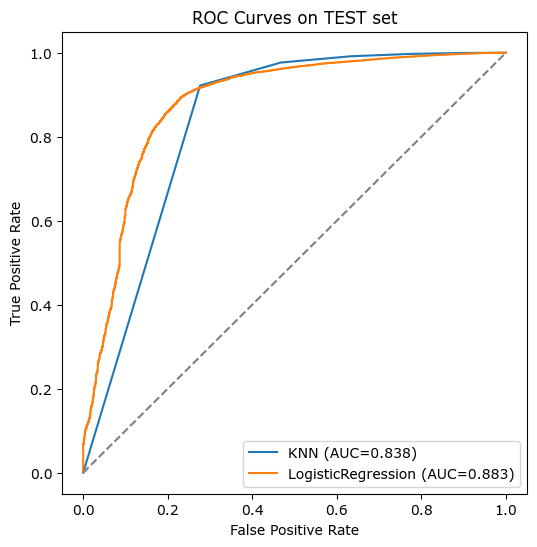

In [50]:
#final evaluation on test set: metrics, times, ROC/AUC
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

test_summary = {}
for name, model in models.items():
    t0 = time.time()
    y_test_pred = model.predict(X_test)
    t1 = time.time()
    test_time = ms_elapsed(t0, t1)

    # score for ROC/AUC
    if hasattr(model, "predict_proba"):
        y_score = model.predict_proba(X_test)[:, 1]
    elif hasattr(model, "decision_function"):
        y_score = model.decision_function(X_test)
    else:
        y_score = None

    acc = accuracy_score(y_test, y_test_pred)
    prec_macro = precision_score(y_test, y_test_pred, average='macro', zero_division=0)
    rec_macro = recall_score(y_test, y_test_pred, average='macro', zero_division=0)
    f1m = f1_score(y_test, y_test_pred, average='macro', zero_division=0)

    test_summary[name] = {
        'accuracy': acc, 'precision_macro': prec_macro, 'recall_macro': rec_macro,
        'f1_macro': f1m, 'confusion': confusion_matrix(y_test, y_test_pred),
        'test_time_ms': test_time, 'y_score': y_score
    }

    print(f"\n{name} TEST")
    print("Confusion matrix:\n", test_summary[name]['confusion'])
    print(f"Accuracy: {acc:.4f}, Precision_macro: {prec_macro:.4f}, Recall_macro: {rec_macro:.4f}, F1_macro: {f1m:.4f}")
    print(f"Test time: {test_time:.1f} ms")

#display results table
test_df = pd.DataFrame(test_summary).T.reset_index().rename(columns={'index':'model'})
display(test_df[['model','accuracy','precision_macro','recall_macro','f1_macro','test_time_ms']])

#plot ROC curves
plt.figure(figsize=(6,6))
for name, info in test_summary.items():
    if info['y_score'] is None:
        continue
    fpr, tpr, _ = roc_curve(y_test, info['y_score'])
    auc = roc_auc_score(y_test, info['y_score'])
    plt.plot(fpr, tpr, label=f"{name} (AUC={auc:.3f})")

plt.plot([0,1],[0,1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves on TEST set')
plt.legend()
plt.show()


In [68]:
#5-fold CV precision on training set
from sklearn.model_selection import StratifiedKFold, cross_val_score
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

print("Cross-val precision (5 folds) on training set:")
for name, model in models.items():
    scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='precision', n_jobs=-1)
    print(f" {name}: mean precision = {scores.mean():.4f}, std = {scores.std():.4f}")


Cross-val precision (5 folds) on training set:
 KNN: mean precision = 0.9756, std = 0.0003
 LogisticRegression: mean precision = 0.9919, std = 0.0004


When comparing KNN and Logistic Regression on this dataset, the two models show noticeably different strengths, which highlights why evaluating multiple classifiers is important. KNN performs best overall with respect to our primary metric, precision, achieving a macro-precision of 0.80 on the test set and an accuracy of 96.8%. This indicates that KNN is much better at avoiding false positives, meaning it rarely predicts a location as suitable (class 1) when it actually isn’t. In the context of turbine site selection, this is important because a false positive could result in choosing a poor or unsafe installation site, which may lead to financial losses or engineering risks. Logistic Regression, on the other hand, achieves much higher recall (0.83 macro-recall), meaning it captures more of the positive cases and produces fewer false negatives. However, this comes at the cost of very low precision for the minority class, leading to a much higher rate of false positives and an overall macro-precision of only 0.58.

The ROC/AUC results also show that Logistic Regression (AUC = 0.883) has stronger probability ranking ability than KNN (AUC = 0.838), but its threshold-based predictions still perform worse under our precision-focused evaluation. Another practical consideration is speed: Logistic Regression is extremely fast at prediction (7 ms), while KNN is slow (~14.5 seconds) because it relies on distance comparisons to the entire training set. Overall, because our goal is to minimise false positives, KNN is the more appropriate model, even though Logistic Regression would be preferable in applications where identifying as many true positives as possible is more important. This comparison illustrates why relying on a single metric or model can be misleading and why model selection must align with the real-world priorities of the task.